<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Batch-Normalization-in-practice,-an-example-with-Keras-and-TensorFlow-2.0" data-toc-modified-id="Batch-Normalization-in-practice,-an-example-with-Keras-and-TensorFlow-2.0-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Batch Normalization in practice, an example with Keras and TensorFlow 2.0</a></span></li><li><span><a href="#Build-a-neural-network-model-with-batch-normalization" data-toc-modified-id="Build-a-neural-network-model-with-batch-normalization-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Build a neural network model with batch normalization</a></span></li></ul></div>

# Batch Normalization in practice, an example with Keras and TensorFlow 2.0

Batch normalization is a technique for training very deep neural networks that standardizes the inputs to a layer for each mini-batch. This has the effect of stabilizing the learning process and dramatically reducing the number of training epochs required to train deep networks.

Batch normalization can be implemented during training by calculating the mean and standard deviation of each input variable to a layer per mini-batch and using these statistics to perform the standardization.

Formally, the batch normalization algorithm [1] is defined as:

![](./i/1_vYBR0bBHcd-zNQf0c6jpg.png)



The benefits of batch normalization are [2]:

   1. A deep neural network can be trained faster: Although each training iteration will be slower because of the extra normalization calculation during the forward pass and the additional hyperparameters to train during backpropagation, it should converge much more quickly; thus, training should be faster overall.
   2. Higher learning rate: Gradient descent generally requires small learning rates for the network to converge. As networks become deeper, gradients become smaller during backpropagation and thus require even more iterations. Using batch normalization allows much higher learning rates, thereby increasing the speed of training.
   3.  Easier to initialize weight: Weight initialization can be difficult, particularly when creating deeper networks. Batch normalization reduces the sensitivity to the initial starting weights.
   
  paper:
 https://arxiv.org/abs/1502.03167

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
iris = load_iris()

# For the purpose of exploring data, let’s load data into a DataFrame

# Load data into a DataFrame
df = pd.DataFrame(iris.data, columns=iris.feature_names)
# Convert datatype to float
df = df.astype(float)
# append "target" and name it "label"
df['label'] = iris.target
# Use string label instead
df['label'] = df.label.replace(dict(enumerate(iris.target_names)))

df.head()

# We notice the label column is a categorical feature and will need to convert it
# to one-hot encoding. Otherwise, our machine learning algorithm won’t be able 
# to directly take in that as input.

# label -> one-hot encoding
label = pd.get_dummies(df['label'], prefix='label')
df = pd.concat([df, label], axis=1)
# drop old label
df.drop(['label'], axis=1, inplace=True)

df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label_setosa,label_versicolor,label_virginica
0,5.1,3.5,1.4,0.2,1,0,0
1,4.9,3.0,1.4,0.2,1,0,0
2,4.7,3.2,1.3,0.2,1,0,0
3,4.6,3.1,1.5,0.2,1,0,0
4,5.0,3.6,1.4,0.2,1,0,0


In [2]:
# Next, let’s create X and y. Keras and TensorFlow 2.0 only take in Numpy array as inputs, 
# so we will have to convert DataFrame back to Numpy array.

# Creating X and yX = df[['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
# 'petal width (cm)']]
# Convert DataFrame into np array
# Creating X and y

X = df[['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']]
# Convert DataFrame into np array
X = np.asarray(X)

y = df[['label_setosa', 'label_versicolor', 'label_virginica']]
# Convert DataFrame into np array
y = np.asarray(y)

In [3]:
# Split the data set in a training set (80%) and a test set (20%)
X_train, X_test, y_train, y_test = train_test_split(
  X,
  y,
  test_size=0.20
)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(120, 4)
(30, 4)
(120, 3)
(30, 3)


# Build a neural network model with batch normalization

There are 3 ways to create a machine learning model with Keras and TensorFlow 2.0. Since we are building a simple fully connected neural network and for simplicity, let’s use the easiest way: Sequential Model with Sequential().

First, let’s import Sequential and BatchNormalization

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization

# Model without batch normalization
model = Sequential([
    Dense(64, input_shape=(4,), activation="relu"),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
]);

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                320       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 195       
Total params: 37,763
Trainable params: 37,763
Non-trainable params: 0
____________________________________________________

In [5]:
model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)
# After that, let's fit our model to the training data.

history = model.fit(
    X_train, 
    y_train, 
    epochs=200, 
    validation_split=0.25, 
    batch_size=40, 
    verbose=2
)

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

Train on 90 samples, validate on 30 samples
Epoch 1/200
90/90 - 1s - loss: 1.0608 - accuracy: 0.3778 - val_loss: 0.9372 - val_accuracy: 0.6667
Epoch 2/200
90/90 - 0s - loss: 0.9151 - accuracy: 0.6667 - val_loss: 0.8343 - val_accuracy: 0.6667
Epoch 3/200
90/90 - 0s - loss: 0.8202 - accuracy: 0.6667 - val_loss: 0.7485 - val_accuracy: 0.6667
Epoch 4/200
90/90 - 0s - loss: 0.7171 - accuracy: 0.6667 - val_loss: 0.6729 - val_accuracy: 0.9000
Epoch 5/200
90/90 - 0s - loss: 0.6418 - accuracy: 0.8667 - val_loss: 0.5933 - val_accuracy: 0.8000
Epoch 6/200
90/90 - 0s - loss: 0.5627 - accuracy: 0.7556 - val_loss: 0.5324 - val_accuracy: 0.8000
Epoch 7/200
90/90 - 0s - loss: 0.4994 - accuracy: 0.8000 - val_loss: 0.4783 - val_accuracy: 0.9000
Epoch 8/200
90/90 - 0s - loss: 0.4504 - accuracy: 0.7889 - val_loss: 0.4331 - val_accuracy: 0.9333
Epoch 9/200
90/90 - 0s - loss: 0.3975 - accuracy: 0.9889 - val_loss: 0.3942 - val_accuracy: 0.9333
Epoch 10/200
90/90 - 0s - loss: 0.3558 - accuracy: 0.9556 - val_l

Epoch 83/200
90/90 - 0s - loss: 0.0099 - accuracy: 1.0000 - val_loss: 0.2938 - val_accuracy: 0.9333
Epoch 84/200
90/90 - 0s - loss: 0.0113 - accuracy: 1.0000 - val_loss: 0.2889 - val_accuracy: 0.9333
Epoch 85/200
90/90 - 0s - loss: 0.0104 - accuracy: 1.0000 - val_loss: 0.2600 - val_accuracy: 0.9333
Epoch 86/200
90/90 - 0s - loss: 0.0099 - accuracy: 1.0000 - val_loss: 0.3364 - val_accuracy: 0.9333
Epoch 87/200
90/90 - 0s - loss: 0.0139 - accuracy: 1.0000 - val_loss: 0.2974 - val_accuracy: 0.9333
Epoch 88/200
90/90 - 0s - loss: 0.0171 - accuracy: 0.9889 - val_loss: 0.2530 - val_accuracy: 0.9333
Epoch 89/200
90/90 - 0s - loss: 0.0100 - accuracy: 1.0000 - val_loss: 0.4070 - val_accuracy: 0.9333
Epoch 90/200
90/90 - 0s - loss: 0.0414 - accuracy: 0.9778 - val_loss: 0.3302 - val_accuracy: 0.9333
Epoch 91/200
90/90 - 0s - loss: 0.0137 - accuracy: 1.0000 - val_loss: 0.2421 - val_accuracy: 0.9333
Epoch 92/200
90/90 - 0s - loss: 0.0182 - accuracy: 1.0000 - val_loss: 0.3398 - val_accuracy: 0.9333


Epoch 165/200
90/90 - 0s - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.4562 - val_accuracy: 0.9333
Epoch 166/200
90/90 - 0s - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.4681 - val_accuracy: 0.9333
Epoch 167/200
90/90 - 0s - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.4497 - val_accuracy: 0.9333
Epoch 168/200
90/90 - 0s - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.4100 - val_accuracy: 0.9333
Epoch 169/200
90/90 - 0s - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.4369 - val_accuracy: 0.9333
Epoch 170/200
90/90 - 0s - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.4534 - val_accuracy: 0.9333
Epoch 171/200
90/90 - 0s - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.4244 - val_accuracy: 0.9333
Epoch 172/200
90/90 - 0s - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.4388 - val_accuracy: 0.9333
Epoch 173/200
90/90 - 0s - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.4852 - val_accuracy: 0.9333
Epoch 174/200
90/90 - 0s - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.4895 - val_accurac

30/1 - 0s - loss: 0.2214 - accuracy: 0.9667


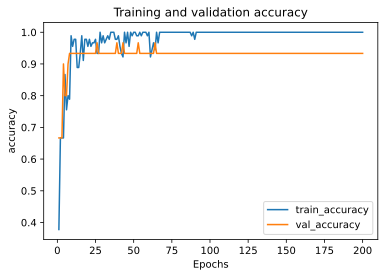

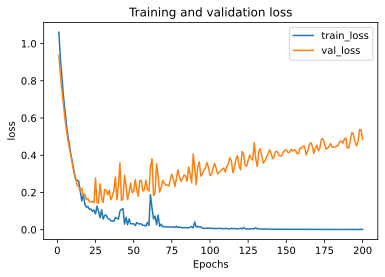

In [6]:
# Evaluate the model on the test set
model.evaluate(X_test, y_test, verbose=2)
plot_metric(history, 'accuracy')
plot_metric(history, 'loss')

Our model has the following specifications:

    The first layer (also known as the input layer) has the input_shape to set the input size (4,)
    The input layer has 64 units, followed by 2 dense layers, each with 128 units. Then there are further 2dense layers, each with 64 units. All these layers use the relu activation function.
    The output Dense layer has 3 units and the softmax activation function.

We can add batch normalization into our model by adding it in the same way as adding Dense layer.

In [7]:
# Model with batch normalization
model = Sequential([
    Dense(64, input_shape=(4,), activation="relu"),
    BatchNormalization(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dense(3, activation='softmax')
]);

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                320       
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dense_7 (Dense)              (None, 128)               8320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_8 (Dense)              (None, 128)               16512     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dense_9 (Dense)              (None, 64)               

In [8]:
model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)
# After that, let's fit our model to the training data.

history = model.fit(
    X_train, 
    y_train, 
    epochs=200, 
    validation_split=0.25, 
    batch_size=40, 
    verbose=2
)

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

Train on 90 samples, validate on 30 samples
Epoch 1/200
90/90 - 2s - loss: 0.7793 - accuracy: 0.7111 - val_loss: 1.0618 - val_accuracy: 0.6667
Epoch 2/200
90/90 - 0s - loss: 0.1934 - accuracy: 0.9333 - val_loss: 1.0521 - val_accuracy: 0.6667
Epoch 3/200
90/90 - 0s - loss: 0.1483 - accuracy: 0.9667 - val_loss: 1.0486 - val_accuracy: 0.6667
Epoch 4/200
90/90 - 0s - loss: 0.1078 - accuracy: 0.9778 - val_loss: 1.0466 - val_accuracy: 0.7000
Epoch 5/200
90/90 - 0s - loss: 0.1855 - accuracy: 0.9444 - val_loss: 1.0451 - val_accuracy: 0.7333
Epoch 6/200
90/90 - 0s - loss: 0.0644 - accuracy: 1.0000 - val_loss: 1.0432 - val_accuracy: 0.9000
Epoch 7/200
90/90 - 0s - loss: 0.0602 - accuracy: 0.9889 - val_loss: 1.0379 - val_accuracy: 0.7667
Epoch 8/200
90/90 - 0s - loss: 0.0475 - accuracy: 0.9889 - val_loss: 1.0349 - val_accuracy: 0.6667
Epoch 9/200
90/90 - 0s - loss: 0.0471 - accuracy: 0.9889 - val_loss: 1.0358 - val_accuracy: 0.6333
Epoch 10/200
90/90 - 0s - loss: 0.0565 - accuracy: 0.9778 - val_l

Epoch 83/200
90/90 - 0s - loss: 0.0058 - accuracy: 1.0000 - val_loss: 0.1767 - val_accuracy: 0.9667
Epoch 84/200
90/90 - 0s - loss: 0.0106 - accuracy: 1.0000 - val_loss: 0.1757 - val_accuracy: 0.9667
Epoch 85/200
90/90 - 0s - loss: 0.0066 - accuracy: 1.0000 - val_loss: 0.1827 - val_accuracy: 0.9667
Epoch 86/200
90/90 - 0s - loss: 0.0122 - accuracy: 0.9889 - val_loss: 0.1914 - val_accuracy: 0.9667
Epoch 87/200
90/90 - 0s - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.1999 - val_accuracy: 0.9667
Epoch 88/200
90/90 - 0s - loss: 0.0056 - accuracy: 1.0000 - val_loss: 0.2078 - val_accuracy: 0.9667
Epoch 89/200
90/90 - 0s - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.2140 - val_accuracy: 0.9667
Epoch 90/200
90/90 - 0s - loss: 0.0285 - accuracy: 0.9778 - val_loss: 0.2460 - val_accuracy: 0.9667
Epoch 91/200
90/90 - 0s - loss: 0.0366 - accuracy: 0.9889 - val_loss: 0.3240 - val_accuracy: 0.9000
Epoch 92/200
90/90 - 0s - loss: 0.0052 - accuracy: 1.0000 - val_loss: 0.3210 - val_accuracy: 0.9000


Epoch 165/200
90/90 - 0s - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.2913 - val_accuracy: 0.9667
Epoch 166/200
90/90 - 0s - loss: 0.0374 - accuracy: 0.9889 - val_loss: 0.2996 - val_accuracy: 0.9667
Epoch 167/200
90/90 - 0s - loss: 0.0088 - accuracy: 1.0000 - val_loss: 0.3021 - val_accuracy: 0.9667
Epoch 168/200
90/90 - 0s - loss: 0.0141 - accuracy: 0.9889 - val_loss: 0.3193 - val_accuracy: 0.9667
Epoch 169/200
90/90 - 0s - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.3744 - val_accuracy: 0.9333
Epoch 170/200
90/90 - 0s - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.4254 - val_accuracy: 0.9333
Epoch 171/200
90/90 - 0s - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.4609 - val_accuracy: 0.9333
Epoch 172/200
90/90 - 0s - loss: 0.0255 - accuracy: 0.9889 - val_loss: 0.4796 - val_accuracy: 0.9333
Epoch 173/200
90/90 - 0s - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.5072 - val_accuracy: 0.9333
Epoch 174/200
90/90 - 0s - loss: 0.0096 - accuracy: 1.0000 - val_loss: 0.5091 - val_accurac

30/1 - 0s - loss: 0.2966 - accuracy: 0.9333


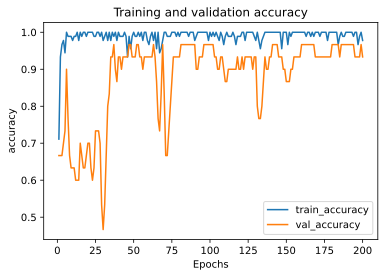

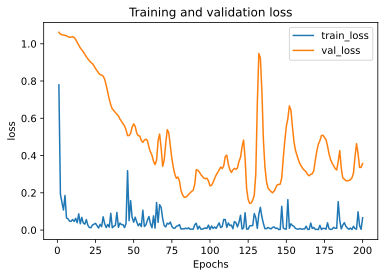

In [9]:
# Evaluate the model on the test set
model.evaluate(X_test, y_test, verbose=2)
plot_metric(history, 'accuracy')
plot_metric(history, 'loss')

BatchNormalization() normalize the activation of the previous layer at each batch and by default, it is using the following values [3]:

    Momentum defaults to 0.99
    The hyperparameter ε defaults to 0.001
    The hyperparameter β defaults to an all-zeros vector
    The hyperparameter γ defaults to an all-ones vector

These can all be changed by adding optional arguments to BatchNormalization() . For example

In [10]:
from tensorflow.keras.initializers import RandomNormal, Constant# Model with default batch normalization
model = Sequential([
    Dense(64, input_shape=(4,), activation="relu"),
    BatchNormalization(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dense(64, activation='relu'),
    BatchNormalization(
        momentum=0.95, 
        epsilon=0.005,
        beta_initializer=RandomNormal(mean=0.0, stddev=0.05), 
        gamma_initializer=Constant(value=0.9)
    ),
    Dense(3, activation='softmax')
]);



RandomNormal() generates a tensor with a normal distribution and Constant() generates a tensor with constant values. By running model.summary() you should get a model summary like below:

In [11]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 64)                320       
_________________________________________________________________
batch_normalization_5 (Batch (None, 64)                256       
_________________________________________________________________
dense_13 (Dense)             (None, 128)               8320      
_________________________________________________________________
batch_normalization_6 (Batch (None, 128)               512       
_________________________________________________________________
dense_14 (Dense)             (None, 128)               16512     
_________________________________________________________________
batch_normalization_7 (Batch (None, 128)               512       
_________________________________________________________________
dense_15 (Dense)             (None, 64)               

Training

Let’s now compile and fit our model with batch normalization. We first compile our model with the following specifications

    Use Adam (adam) optimization algorithm as the optimizer
    Use categorical cross-entropy loss function (categorical_crossentropy) for our multiple-class classification problem
    For simplicity, use accuracy as our evaluation metrics to evaluate the model during training and testing.

In [12]:
model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)
# After that, let's fit our model to the training data.

history = model.fit(
    X_train, 
    y_train, 
    epochs=200, 
    validation_split=0.25, 
    batch_size=40, 
    verbose=2
)

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

Train on 90 samples, validate on 30 samples
Epoch 1/200
90/90 - 2s - loss: 0.9418 - accuracy: 0.6111 - val_loss: 1.0523 - val_accuracy: 0.3333
Epoch 2/200
90/90 - 0s - loss: 0.2697 - accuracy: 0.9222 - val_loss: 1.0246 - val_accuracy: 0.4667
Epoch 3/200
90/90 - 0s - loss: 0.1239 - accuracy: 0.9889 - val_loss: 1.0090 - val_accuracy: 0.3667
Epoch 4/200
90/90 - 0s - loss: 0.1106 - accuracy: 0.9778 - val_loss: 1.0029 - val_accuracy: 0.3667
Epoch 5/200
90/90 - 0s - loss: 0.1236 - accuracy: 0.9778 - val_loss: 1.0002 - val_accuracy: 0.3667
Epoch 6/200
90/90 - 0s - loss: 0.0603 - accuracy: 1.0000 - val_loss: 1.0069 - val_accuracy: 0.3667
Epoch 7/200
90/90 - 0s - loss: 0.0882 - accuracy: 0.9778 - val_loss: 1.0151 - val_accuracy: 0.3667
Epoch 8/200
90/90 - 0s - loss: 0.1042 - accuracy: 0.9556 - val_loss: 1.0134 - val_accuracy: 0.3667
Epoch 9/200
90/90 - 0s - loss: 0.0411 - accuracy: 1.0000 - val_loss: 1.0006 - val_accuracy: 0.3667
Epoch 10/200
90/90 - 0s - loss: 0.0727 - accuracy: 0.9889 - val_l

Epoch 83/200
90/90 - 0s - loss: 0.0200 - accuracy: 1.0000 - val_loss: 0.1342 - val_accuracy: 0.9667
Epoch 84/200
90/90 - 0s - loss: 0.0436 - accuracy: 0.9889 - val_loss: 0.1397 - val_accuracy: 0.9667
Epoch 85/200
90/90 - 0s - loss: 0.0741 - accuracy: 0.9667 - val_loss: 0.1463 - val_accuracy: 0.9667
Epoch 86/200
90/90 - 0s - loss: 0.0195 - accuracy: 1.0000 - val_loss: 0.1476 - val_accuracy: 0.9667
Epoch 87/200
90/90 - 0s - loss: 0.0262 - accuracy: 1.0000 - val_loss: 0.1482 - val_accuracy: 0.9667
Epoch 88/200
90/90 - 0s - loss: 0.0167 - accuracy: 1.0000 - val_loss: 0.1457 - val_accuracy: 0.9667
Epoch 89/200
90/90 - 0s - loss: 0.0213 - accuracy: 0.9889 - val_loss: 0.1455 - val_accuracy: 0.9667
Epoch 90/200
90/90 - 0s - loss: 0.0285 - accuracy: 0.9889 - val_loss: 0.1427 - val_accuracy: 0.9667
Epoch 91/200
90/90 - 0s - loss: 0.0180 - accuracy: 0.9889 - val_loss: 0.1355 - val_accuracy: 0.9667
Epoch 92/200
90/90 - 0s - loss: 0.0663 - accuracy: 0.9889 - val_loss: 0.1278 - val_accuracy: 0.9667


Epoch 165/200
90/90 - 0s - loss: 0.0315 - accuracy: 0.9889 - val_loss: 0.1236 - val_accuracy: 0.9667
Epoch 166/200
90/90 - 0s - loss: 0.0457 - accuracy: 0.9667 - val_loss: 0.1071 - val_accuracy: 0.9667
Epoch 167/200
90/90 - 0s - loss: 0.0052 - accuracy: 1.0000 - val_loss: 0.0903 - val_accuracy: 0.9667
Epoch 168/200
90/90 - 0s - loss: 0.0259 - accuracy: 0.9889 - val_loss: 0.0845 - val_accuracy: 0.9667
Epoch 169/200
90/90 - 0s - loss: 0.0095 - accuracy: 1.0000 - val_loss: 0.0835 - val_accuracy: 0.9667
Epoch 170/200
90/90 - 0s - loss: 0.0385 - accuracy: 0.9889 - val_loss: 0.0780 - val_accuracy: 0.9667
Epoch 171/200
90/90 - 0s - loss: 0.0219 - accuracy: 0.9889 - val_loss: 0.0784 - val_accuracy: 0.9667
Epoch 172/200
90/90 - 0s - loss: 0.0163 - accuracy: 0.9889 - val_loss: 0.0813 - val_accuracy: 0.9667
Epoch 173/200
90/90 - 0s - loss: 0.0265 - accuracy: 0.9889 - val_loss: 0.1119 - val_accuracy: 0.9667
Epoch 174/200
90/90 - 0s - loss: 0.0515 - accuracy: 0.9778 - val_loss: 0.1607 - val_accurac

30/1 - 0s - loss: 0.1922 - accuracy: 0.9333


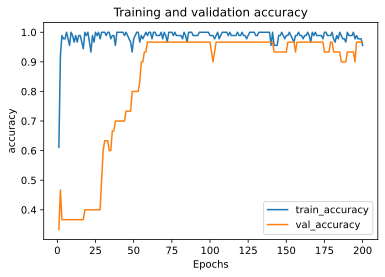

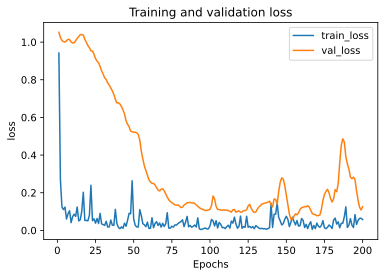

In [13]:
# Evaluate the model on the test set
model.evaluate(X_test, y_test, verbose=2)
plot_metric(history, 'accuracy')
plot_metric(history, 'loss')